# TSP Data Extraction

First we download the SATCAT catalogue and the TLE data from https://celestrak.com/. In this example, we will take the debris data of the irdium-33 satellite from the collision with cosmos-2251.

In [1]:
import urllib.request
import os

def download(url, file_name):
    
    if not os.path.exists(file_name):
        print("downloading data from " + str(url))
        with open(file_name, "wb") as file:
            response = urllib.request.urlopen(url)
            file.write(response.read())
    
PATH_TO_SATCAT = "data/satcat.txt"
PATH_TO_DEBRIS_TLE = "data/iridium-33-debris.txt"

if not os.path.exists("data"):
    print("Creating data folder")
    os.makedirs("data")
    
download("https://celestrak.com/pub/satcat.txt", PATH_TO_SATCAT)
download("https://www.celestrak.com/NORAD/elements/iridium-33-debris.txt", PATH_TO_DEBRIS_TLE)

Creating data folder
downloading data from https://celestrak.com/pub/satcat.txt
downloading data from https://www.celestrak.com/NORAD/elements/iridium-33-debris.txt


The function <code> compute_static_TSP_data </code> computes an instance of a static city selection travelling salesman problem based on the TLE data and SATCAT catalogue that is passed to the function. For the compuation of the edges, the three impulsive approximation from the pykep module is used. For the preferences, the radarA value of the SATCAT catalogue has been chosen. A dictionary with keys 'A' (distance matrix), 'P' preference values and 'ids' for the corresponding debris ids is returned.

In [2]:
from preprocessing import data_processing

static_data = data_processing.compute_static_TSP_data(PATH_TO_SATCAT, PATH_TO_DEBRIS_TLE)

Preprocessing indices for three impulse approximation



Computing cost approximations for static TSP


The resulting distance matrix:

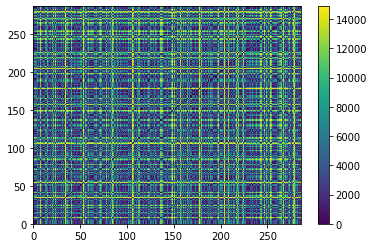

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(static_data['A'])
plt.colorbar()
plt.show()

In [4]:
nDebris = static_data['P'].shape[0]
for i in range(0, nDebris, 35):
    print(f"Debris {i} in the CS-TSP has the catalog number {static_data['ids'][i]} and radar area {static_data['P'][i]}")

Debris 0 in the CS-TSP has the catalog number 1997-051C and radar area 2.519
Debris 35 in the CS-TSP has the catalog number 1997-051BU and radar area 0.0871
Debris 70 in the CS-TSP has the catalog number 1997-051ET and radar area 0.043
Debris 105 in the CS-TSP has the catalog number 1997-051JU and radar area 0.033
Debris 140 in the CS-TSP has the catalog number 1997-051NY and radar area 0.0011
Debris 175 in the CS-TSP has the catalog number 1997-051SA and radar area 0.0115
Debris 210 in the CS-TSP has the catalog number 1997-051VK and radar area 0.0193
Debris 245 in the CS-TSP has the catalog number 1997-051YQ and radar area 0.0105
Debris 280 in the CS-TSP has the catalog number 1997-051ABE and radar area 0.005


Now, we will generate data for the dynamic city selection TSP. To do so, we need to pass the timepoints in which a transfer is allowed. We can use the convenience funktion <code> compute_epochs </code> to compute an array of epochs. The function takes three arguments: the starting day (as julian date from 2000), the number of epochs and the distance of days between the sampling.

In [5]:
# 7350 julian date 2000: 15.2.2019
# 52 time points, every week one, total period of one year
epochs = data_processing.compute_epochs(7350,52,7)
dynamic_data = data_processing.compute_dynamic_TSP_data(PATH_TO_SATCAT, PATH_TO_DEBRIS_TLE, epochs)

Preprocessing indices for dynamic three impulse approximation



Computing cost approximations for dynamic TSP


We will plot the costs of transferring from debris piece 2 to debris piece 3 over time

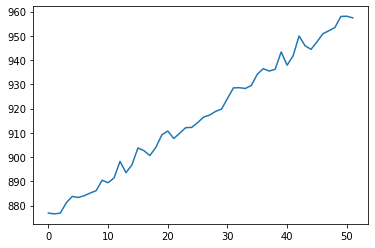

In [6]:
plt.plot(dynamic_data['A'][2,3,:])
plt.show()

One approach in this thesis was to use linear regression to reduce the number of parameters to two for each pair of debris pieces. we can use the convenience function <code>compute_regression_for_matrix</code> for obtaining the parameters.

Computing regression parameters


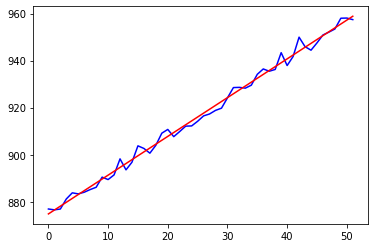

In [7]:
regr_params = data_processing.compute_regression_for_matrix(dynamic_data['A'])

b = regr_params[2,3,0]
m = regr_params[2,3,1]
nEpochs = dynamic_data['A'].shape[2]

y_hat = [b + m*i for i in range(nEpochs)]

plt.plot(dynamic_data['A'][2,3,:], 'b')
plt.plot(y_hat, 'r')

plt.show()

# Optimization

For the mixed integer programs, we will use the optimization functions from the python files mips_static and mips_dynamic. We will begin with the static problem formulation. The supported subtour elimination constraints are F1, F3, T1, T2, seq. As an input, these functions expect that a center is at 0, we will put a leading zero to our data to find a hamiltonian path of the space debris.

In [8]:
from optimization import mips_static

# reduce input size for faster solution
A = static_data['A'][:150,:150]
P = static_data['P'][:150]

A, P = data_processing.add_leading_zero_static(A, P)

res = mips_static.TSP_static(A, P, budget = 1000, SEC_TYPE = "F1")

Academic license - for non-commercial use only
Optimize a model with 23104 rows, 45451 columns and 158703 nonzeros
Variable types: 22650 continuous, 22801 integer (22801 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e-04, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 0.1113000
Presolve removed 19946 rows and 39867 columns
Presolve time: 0.28s
Presolved: 3158 rows, 5584 columns, 19298 nonzeros
Variable types: 2727 continuous, 2857 integer (2857 binary)

Root relaxation: objective 7.044805e+00, 3323 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.04481    0   82    0.11130    7.04481  6230%     -    0s
H    0     0                       2.5190000    7.04481   180%     -    0s
H    0     0                       3.9297000    7.04481  79.3%  

In [9]:
tour = mips_static.get_static_tour(res)


Final: 5.2448

Node included:
0 1 2 3 4 5 19 27 32 48 66 75 88 120 146 
Edges used:
0-5, 1-75, 2-19, 3-146, 4-88, 5-2, 19-32, 27-0, 32-48, 48-120, 66-3, 75-27, 88-1, 120-66, 146-4, 

We can plot the result by calling the module plot. The plot will show the 

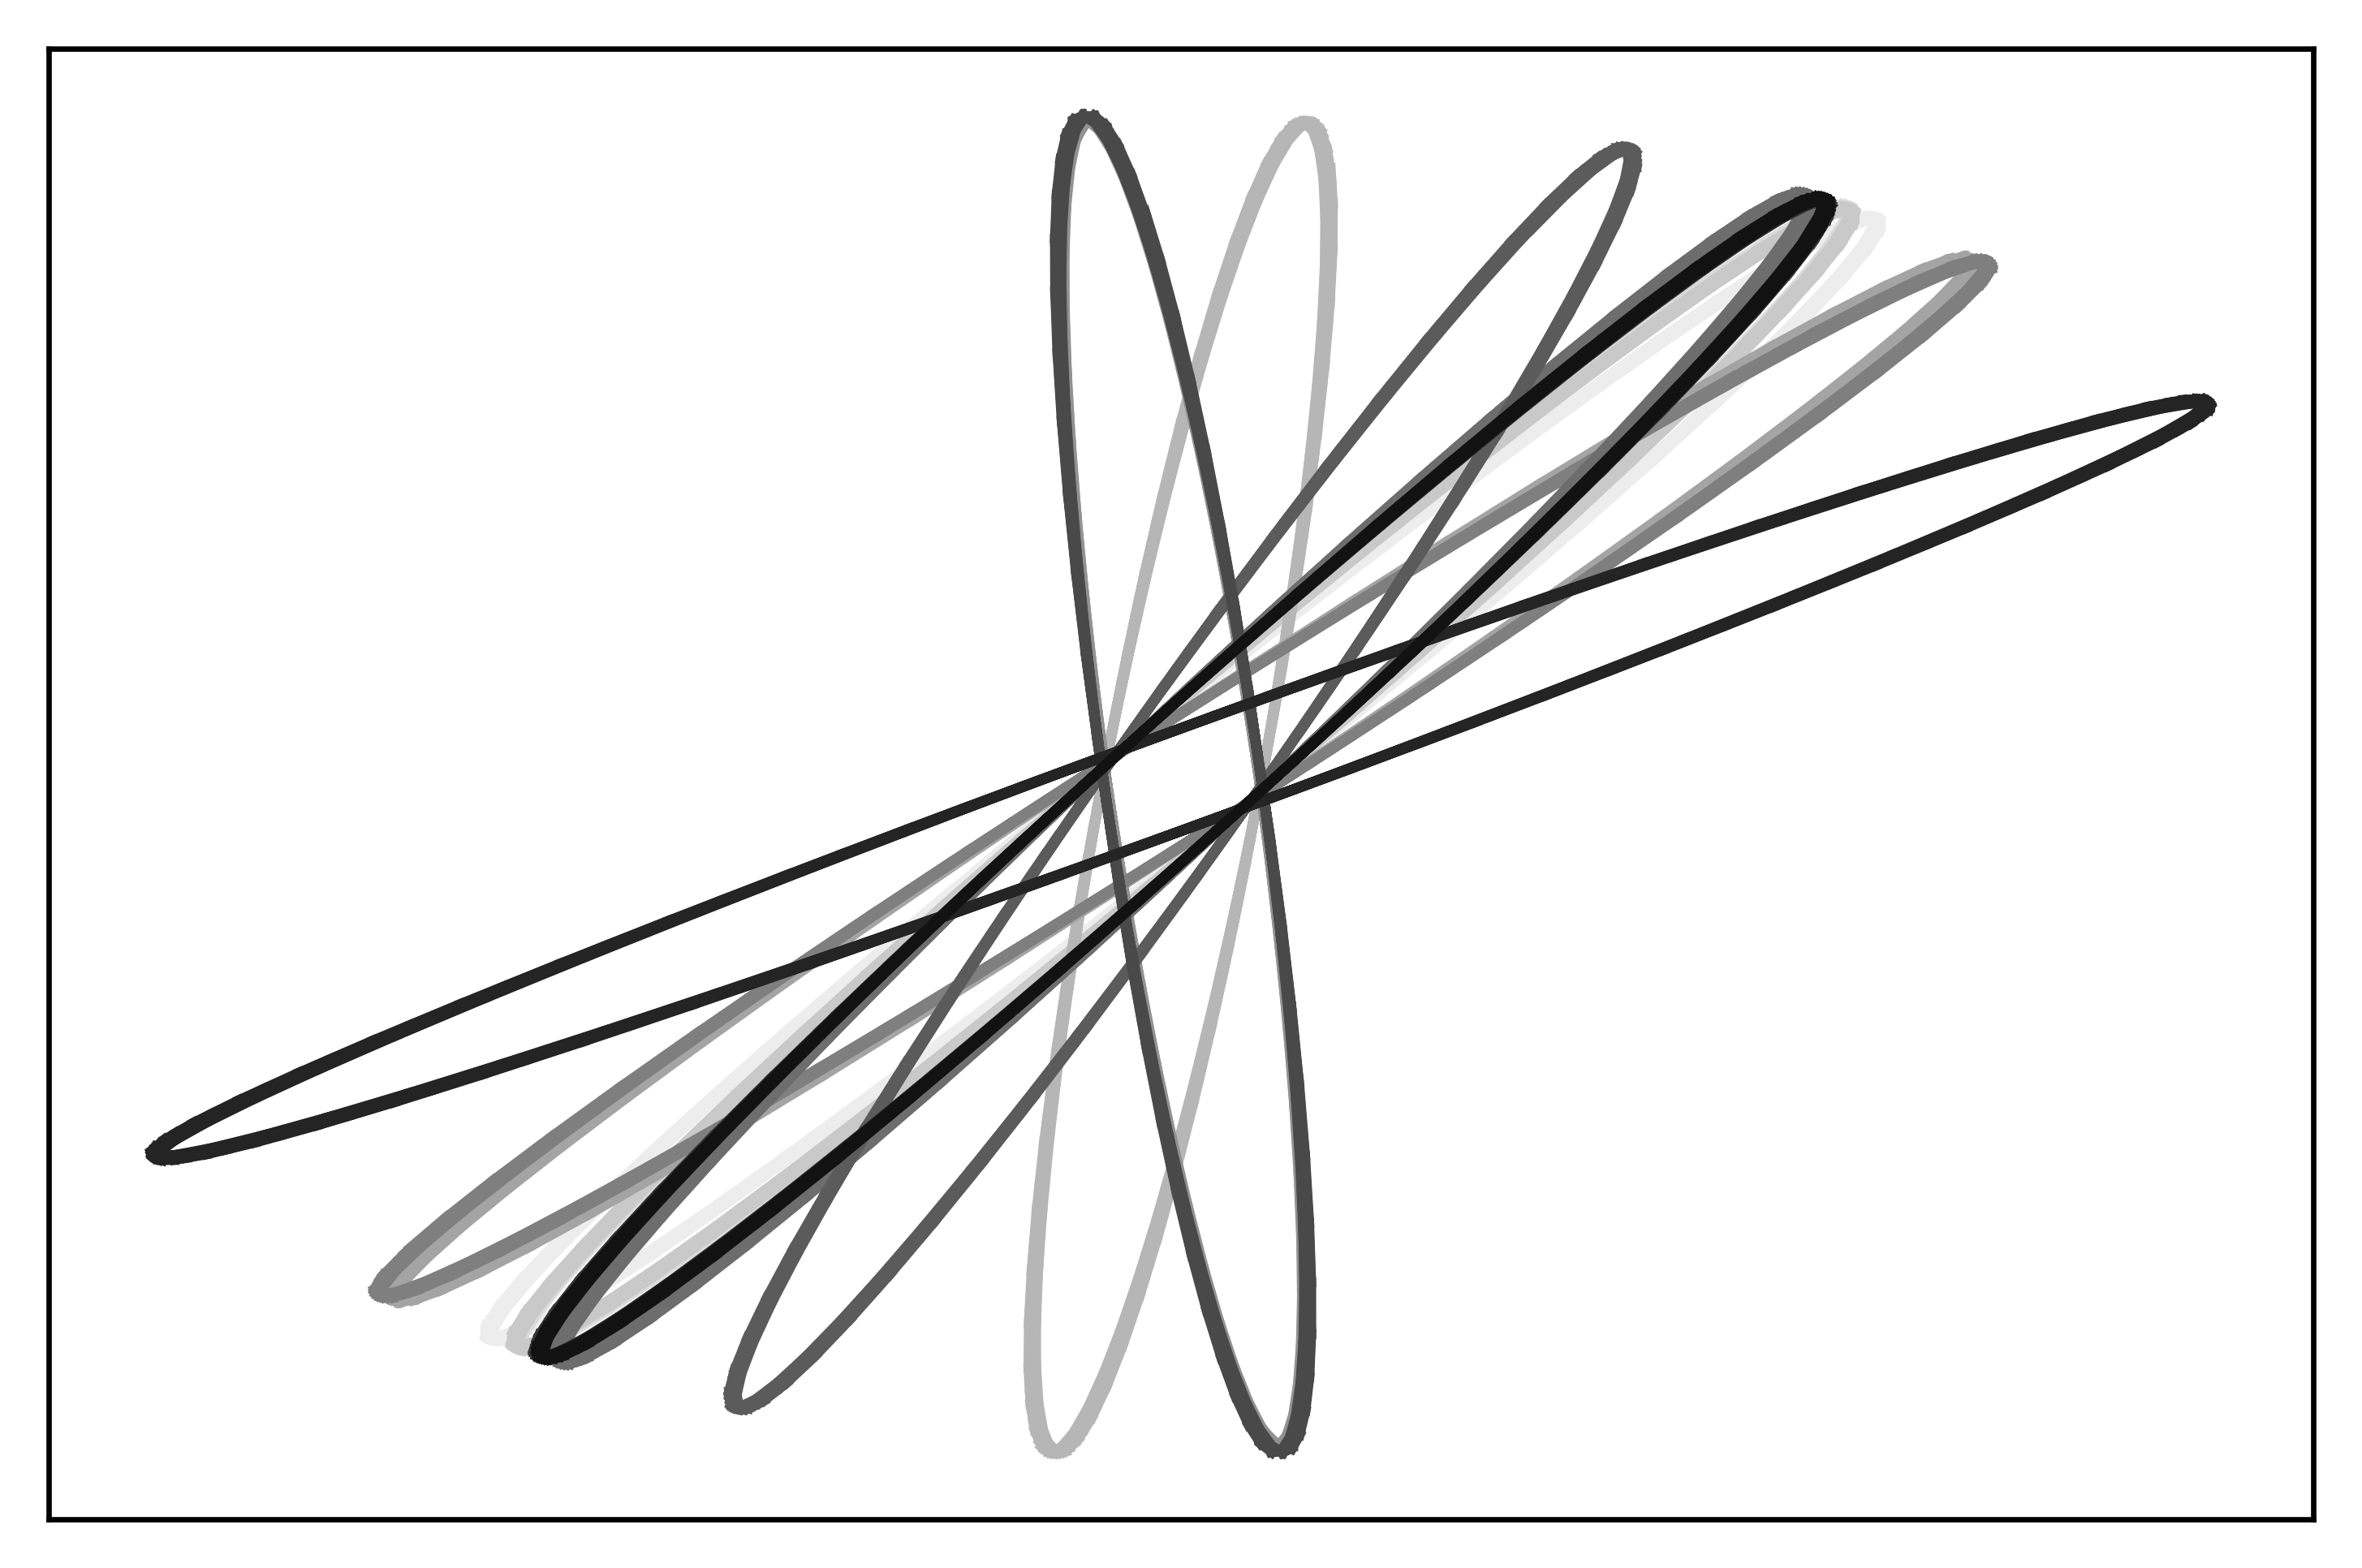

In [10]:
from visualization import plot

# order tour
tour = mips_static.order_cycle_edges(tour)

# remove leading zero
indices_ordered = [t[0]-1 for t in tour[1:]]

line1_list = [static_data['line1'][i] for i in indices_ordered]
line2_list = [static_data['line2'][i] for i in indices_ordered]

tle_list = list(zip(line1_list, line2_list))

plot.plot_orbits_2d(tle_list, 2020, 2, from_day = 15, until_day = 16)

Now we will continue with the dynamic problem formulation. The supported subtour elimination constraints are DT1, DF1, DF2 and based on static variants: F1, F3, T1, T2, seq

In [11]:
from optimization import mips_dynamic

# reduce input size for faster solution
A = dynamic_data['A'][:50, :50, :]
P = dynamic_data['P'][:50]
params = regr_params[:50, :50, :]

A, P, params = data_processing.add_leading_zero_dynamic(A, P, params)

In [12]:
res = mips_dynamic.TSP_dynamic(A, P, transfer_duration = 1, budget = 1000, regr_params = params, SEC_TYPE = "DT1")

Optimize a model with 153 rows, 132651 columns and 647752 nonzeros
Variable types: 0 continuous, 132651 integer (132651 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [9e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 21 rows and 119932 columns
Presolve time: 0.39s
Presolved: 132 rows, 12719 columns, 62993 nonzeros
Found heuristic solution: objective 0.0850000
Variable types: 0 continuous, 12719 integer (12719 binary)

Root relaxation: objective 6.844428e+00, 292 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.84443    0   64    0.08500    6.84443  7952%     -    0s
H    0     0                       2.5190000    6.84443   172%     -    0s
H    0     0                       3.9629000    6.84443  72.7%     -   

In [13]:
tour_times = mips_dynamic.get_times_DT1(res)


Final: 4.5866

Node included:
0 1 3 5 11 21 30 35 39 48 
Edges used:
0-39 at 0
39-5 at 1
5-11 at 4
11-3 at 45
3-35 at 46
35-21 at 47
21-48 at 48
48-1 at 49
1-30 at 50
30-0 at 51


We can also apply a genetic algorithm for a solution.

In [14]:
from optimization import genetic

gen = genetic.GA(A, P, transfer_time = 1, budget = 1000)

There are various parameters that can be adjusted

In [15]:
# population size for every execution of genetic algorithm
gen.set_parameter("population size", 500)

# probability for a crossover
gen.set_parameter("crossover rate", 0.3)

# ratio of individuals replaced in each iteration
gen.set_parameter("dying rate", 0.6)

# probability of random survival
gen.set_parameter("survival rate", 0.1)

# number iterations for each genetic algorithm
gen.set_parameter("nIterations", 200)

# genetic algorithm runs nFittest times
# each time the fittest individual will be returned
# for creating a final population and application of
# the genetic algorithm
gen.set_parameter("nFittest", 40)

Finally, run the genetic algorithm and print the solution

In [ ]:
ind = gen.run()
print(ind)

We can plot the evolution of the fittest individual for every iteration.

In [ ]:
gen.plot()